In [1]:
# load functions
%run ../utils/functions.ipynb

In [2]:

# region for plotting

stlat=30.0
edlat=32.0
stlon=30.0
edlon=32.0

# 数据区域范围
data_stlat = stlat
data_edlat = edlat
data_stlon = stlon
data_edlon = edlon

# 投影方式
projection = "M11c"

# 离散点数
Nlat=101
Nlon=101

# 画图指定深度
all_dep = [10,30]


In [3]:
# inversion result model
test_path = "OUTPUT_FILES_inv_abs"
target_fname = "OUTPUT_FILES/%s/out_data_sim_group_0.h5"%(test_path)   # 检测板反演的最终模型
target_Nstep = "0040"
ref_fname = "OUTPUT_FILES/%s/out_data_sim_group_0.h5"%(test_path)  # 检测板反演的初始模型
ref_Nstep = "0000"
grid_fname = "OUTPUT_FILES/%s/out_data_grid.h5"%(test_path)                # 网格文件
output = "%s_%s"%(test_path,target_Nstep)
fname = "OUTPUT_FILES/OUTPUT_FILES_signal/src_rec_file_forward.dat"

# 插值获得画图数据
target_model = read_model_file_horizontal(grid_fname,target_fname,target_Nstep,data_stlat,data_edlat,data_stlon,data_edlon,Nlat,Nlon,all_dep)
ref_model = read_model_file_horizontal(grid_fname,ref_fname,ref_Nstep,data_stlat,data_edlat,data_stlon,data_edlon,Nlat,Nlon,all_dep)     # initiai model
# ref_model = ave_model(target_model)

# read src_rec file for evlat, evlon, stlat, stlon
[lat_ev, lon_ev, lat_st, lon_st] = read_src_rec_file(fname)

<KeysViewHDF5 ['model']>
<KeysViewHDF5 ['model']>


In [4]:
# -------------------- 深度剖面画图 -------------------------
import pygmt
from pygmt.clib import Session
import os

try:
    os.mkdir("img")
except:
    print("dir models exists")



dlat = (edlat-stlat)/(Nlat-1)
dlon = (edlon-stlon)/(Nlat-1)

# 图片位置
xshift = [ 3,   13,   13,  -26, 13, 13, -26, 13, 13 ]
yshift = [ 80,   0,    0,  -15,  0,  0, -15, 0,  0  ]

frame = [
    ["xa2","ya2","NsWe"],["xa2","ya2","Nswe"],["xa2","ya2","NswE"],
    ["xa2","ya2","nsWe"],["xa2","ya2","nswe"],["xa2","ya2","nswE"],
    ["xa2","ya2","nSWe"],["xa2","ya2","nSwe"],["xa2","ya2","nSwE"],
]

subfigure = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']


dir models exists


In [5]:
# -------------------------- 速度结构 --------------------------------

vel_per     = 6     # 颜色棒范围

# 开始画图
with pygmt.clib.Session() as session:
    session.call_module('gmtset', 'FONT 20p')
fig = pygmt.Figure()
pygmt.config(IO_SEGMENT_MARKER="<<<")

for i in range(0,len(all_dep)):
    print('plotting: dep %3d'%(all_dep[i]))
    pert = np.full(Nlat*Nlon,-100.0)
    lon = np.full(Nlat*Nlon,-100.0)
    lat = np.full(Nlat*Nlon,-100.0)

    for igrid in range(0,Nlat*Nlon):
        pert[igrid] = (target_model[i,igrid,3]-ref_model[i,igrid,3])/ref_model[i,igrid,3]*100
        lon[igrid] = target_model[i,igrid,2]
        lat[igrid] = target_model[i,igrid,1]

    # 生成 grd 文件
    grid = pygmt.surface(x=lon, y=lat, z=pert, spacing=(dlon/2, dlat/2), region=[stlon, edlon, stlat, edlat])

    # ----------- 构造 colorbar ---------------- 
    pygmt.makecpt(cmap="seis", series=[-vel_per, vel_per], background = True)


    # ----------- 画布 ----------------
    fig.shift_origin(xshift=xshift[i],yshift = yshift[i])
    fig.basemap(
        frame=frame[i],                # 坐标轴 -B 的属性  "xa10f5+lLABELNAME" a 表示annotation 的间距, f 表示线的间距, l表示label名称
        projection=projection,  # 投影方式
        region=[stlon,edlon,stlat,edlat],       # 区域范围    
    )

    # ----------- 画 map ----------------
    fig.grdimage(
        frame=frame[i],
        grid = grid,
        projection=projection,  # 投影方式
        region=[stlon,edlon,stlat,edlat],       # 区域范围
    )

    # ---------- 画地震台站 ----------------
    fig.plot(x = lon_ev, y = lat_ev, size = [0.03]*len(lat_ev),style = "c", fill = "black")

    # ----------- 画区域台站 ----------------
    fig.plot(x = lon_st, y = lat_st, size = [0.3]*len(lat_st),style = "t",fill = "black",pen = "0.5p,white")

    # ----------- 一些注记 ----------------
    fig.text(text="Depth = %3d km"%(all_dep[i]), x=31.5, y=30.4, font="18p,Helvetica-Bold,black", fill="white")
    fig.text(text="Vp = %4.2f km/s"%(ref_model[i,0,6]), x=31.5, y=30.2, font="18p,Helvetica-Bold,black", fill="white")
    # fig.text(text=subfigure[i], x=98, y=20.5, font="18p,Helvetica-Bold,black", fill="white")

fig.shift_origin(xshift = 2, yshift = -2)
fig.colorbar(frame = ["a2f1","x+lln(m%d/m00)"%(int(target_Nstep)),"y+l(%)"], position="+w7c/0.5c+h", ) # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平

fig.savefig('img/%s_vel.jpg'%(output))

plotting: dep  10
plotting: dep  30


plotting: dep  10
plotting: dep  30


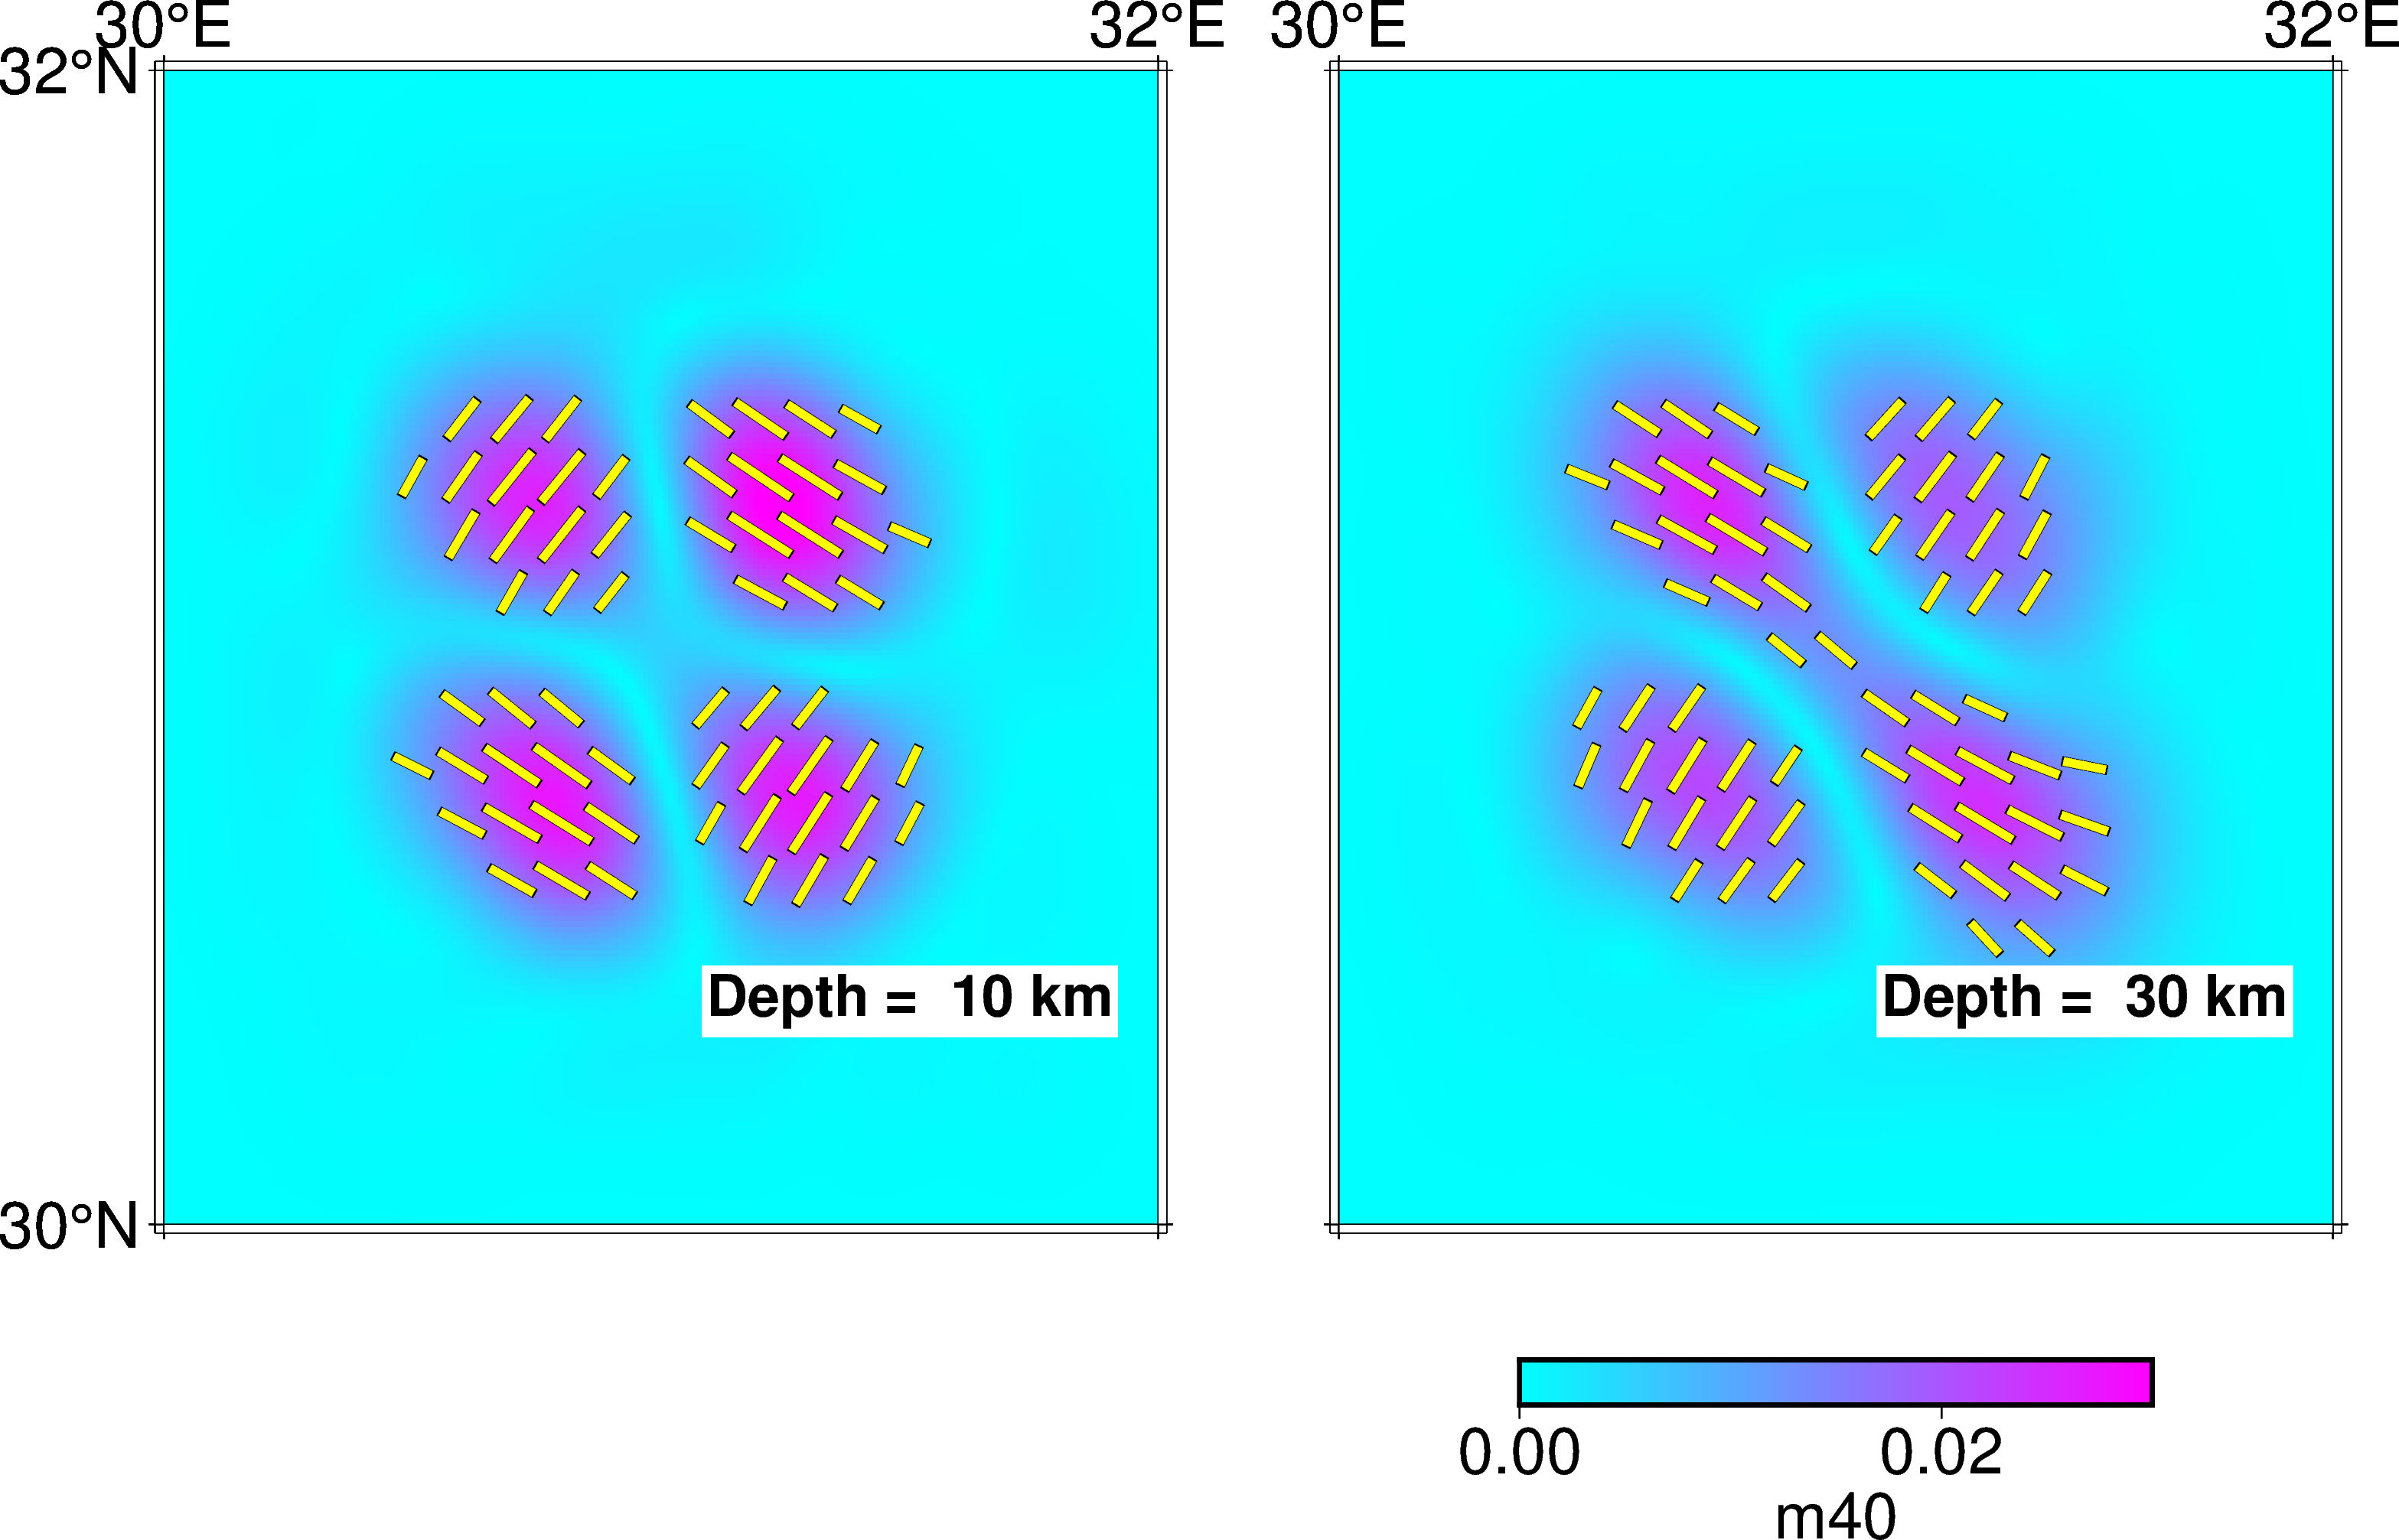

In [6]:
# -------------------------- 各向异性结构 --------------------------------
import math

ani_per = 0.03  # 颜色棒范围

RAD2DEG = 180/math.pi

# 开始画图
with pygmt.clib.Session() as session:
    session.call_module('gmtset', 'FONT 20p')
fig = pygmt.Figure()
pygmt.config(IO_SEGMENT_MARKER="<<<")     

for i in range(0,len(all_dep)):
    
    # data arrangement
    print('plotting: dep %3d'%(all_dep[i]))
    perturbation = np.full(Nlat*Nlon,-100.0)
    lon = np.full(Nlat*Nlon,-100.0)
    lat = np.full(Nlat*Nlon,-100.0)
    eta = np.full(Nlat*Nlon,-100.0)
    xi = np.full(Nlat*Nlon,-100.0)
    epsilon = np.full(Nlat*Nlon,-100.0)
    for igrid in range(0,Nlat*Nlon):
        lon[igrid] = target_model[i,igrid,2]
        lat[igrid] = target_model[i,igrid,1]
        eta[igrid] = target_model[i,igrid,5]
        xi[igrid] = target_model[i,igrid,4]
        epsilon[igrid] = math.sqrt(xi[igrid]**2 + eta[igrid]**2)

    lat_gap = 5; lon_gap = 5
    N_lat_ani = int(Nlat/lat_gap)
    N_lon_ani = int(Nlon/lon_gap)
    
    lat_ani = []
    lon_ani = []
    xi_ani =  []
    eta_ani = []
    sigma = []
    epsilon_ani = []
    psi_ani =  []
    igrid_ani = 0
    for i_lat in range(N_lat_ani):
        for i_lon in range(N_lon_ani):
            igrid = i_lat*lat_gap*Nlon + i_lon*lon_gap

            tmp_xi = target_model[i,igrid,4]
            tmp_eta = target_model[i,igrid,5]
            tmp_epsilon = math.sqrt(tmp_xi**2 + tmp_eta**2)
            if (tmp_epsilon > 0.01):
                lat_ani.append(target_model[i,igrid,1]) 
                lon_ani.append(target_model[i,igrid,2])
                
                xi_ani.append(tmp_xi)
                eta_ani.append(tmp_eta)
                epsilon_ani.append(tmp_epsilon)
                if (tmp_epsilon == 0):
                    psi_ani.append(0)
                else:
                    tmp = math.acos(tmp_xi/tmp_epsilon)
                    if (tmp_eta>0):
                        psi_ani.append(tmp/2*RAD2DEG)
                        # psi_ani.append(tmp/2*RAD2DEG)
                    else:
                        psi_ani.append((2*math.pi-tmp)/2*RAD2DEG)
                        # psi_ani.append((2*math.pi-tmp)/2*RAD2DEG)

    # 生成 grd 文件
    grid = pygmt.surface(x=lon, y=lat, z=epsilon, spacing=(dlon/2, dlat/2), region=[stlon, edlon, stlat, edlat])

    # ----------- 构造 colorbar ---------------- 
    pygmt.makecpt(cmap="cool", series=[0, ani_per],background=True)


    # ----------- 画布 ----------------
    fig.shift_origin(xshift=xshift[i],yshift = yshift[i])
    fig.basemap(
        frame=frame[i],                # 坐标轴 -B 的属性  "xa10f5+lLABELNAME" a 表示annotation 的间距, f 表示线的间距, l表示label名称
        projection=projection,  # 投影方式
        region=[stlon,edlon,stlat,edlat],       # 区域范围
    )


    # ----------- 画 map ----------------
    fig.grdimage(
        frame=frame[i],
        grid = grid,
        projection=projection,  # 投影方式
        region=[stlon,edlon,stlat,edlat],       # 区域范围
    )



    try:
        # fig.plot( x = lon_ani, y = lat_ani, direction = [psi_ani,np.full(len(psi_ani),0.2)], pen = "1p,red", style ="v0c")
        # fig.plot( x = lon_ani, y = lat_ani, direction = [psi_ani,np.full(len(psi_ani),-0.2)], pen = "1p,red", style ="v0c")

        # 0.005 - 0.05  ->  0.2 - 0.6
        length = []
        for tmp_i in range(0,len(epsilon_ani)):
            length.append(min((epsilon_ani[tmp_i]-0.005)/0.045*0.4+0.2,0.6))
        length = np.array(length)

        fig.plot( x = lon_ani, y = lat_ani, direction = [psi_ani,np.full(len(psi_ani),length)], pen = "3p,black", style ="v0c")
        fig.plot( x = lon_ani, y = lat_ani, direction = [psi_ani,np.full(len(psi_ani),-length)], pen = "3p,black", style ="v0c")
        
        fig.plot( x = lon_ani, y = lat_ani, direction = [psi_ani,np.full(len(psi_ani),length-0.02)], pen = "2.6p,yellow1", style ="v0c")
        fig.plot( x = lon_ani, y = lat_ani, direction = [psi_ani,np.full(len(psi_ani),-length+0.02)], pen = "2.6p,yellow1", style ="v0c")
    
    except:
        pass


    # ----------- 一些注记 ----------------
    fig.text(text="Depth = %3d km"%(all_dep[i]), x=31.5, y=30.4, font="18p,Helvetica-Bold,black", fill="white")
    # fig.text(text="Vp = %4.2f km/s"%(ave_target_model[i,0,6]), x=39.5, y=36.5, font="18p,Helvetica-Bold,black", fill="white")
    # fig.text(text=subfigure[i], x=98, y=20.5, font="18p,Helvetica-Bold,black", fill="white")

fig.shift_origin(xshift=2,yshift = -2)
fig.colorbar(frame = ["a0.02","x+lm%d"%(int(target_Nstep))], position="+w7c/0.5c+h") # +e,默认是双箭头，f表示forward，b表示background ，w表示长宽，h表示水平

# fig.savefig('img/%s_ani.jpg'%(output))
fig.show()